# Zyfra Gold Extraction Prediction 
---

 The project task is to utilize machine learning to predict how much gold will result from the processing of gold ore. Two values will be predicted: rougher concentrate recovery and final concentrate recovery. 

 **The Extraction Process:**
 1. Flotation: ore is fed into a float bank to separate AU concentrate and rougher tails
 2. Purification:  ore is sent through a **two** stage purification process 


### Prepare the Data
---

In [2]:
# Add Necessary Packages 

# Data Prep Packages 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation Packages
from sklearn.metrics import mean_absolute_error
from scipy.stats import gaussian_kde
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Visualization Package 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in the data 
try:
    # Attempt to read the data
    full = pd.read_csv('datasets/gold_recovery_full.csv', parse_dates=['date'])
    test = pd.read_csv('datasets/gold_recovery_test.csv', parse_dates=['date'])
    train = pd.read_csv('datasets/gold_recovery_train.csv', parse_dates=['date'])
    # If successful, print Confirmation
    print("The data has been read in as full, test, and train.")
except Exception as e:
    # If an error occurs, print an error message
    print("Error reading data:", e)
    print("To get the data sets please visit: https://github.com/le-crupi64/Zyfra-Gold-Extraction-Prediction/tree/main/Datasets")

The data has been read in as full, test, and train.


#### Verify Recovery Calculation and Find the Mean Absolute Error Between Calculations and the Feature Value

**The following formula will be used to simulate the recovering of gold from gold ore:**

$Recovery=_{F*(C-T)}^{C*(F-T)}*100$

- C - share of gold in the concentrate right after flotation/after purification (for finding the final concentrate recovery)
- F — share of gold in the feed before flotation / in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold in the rougher tails right after flotation / after purification (for finding the final concentrate recovery)

In [4]:

def recovery(df, c, f, t):
    numerator = df[c] * (df[f] - df[t])
    denominator = df[f] * (df[c] - df[t])
    
    # Make exception for NaN values
    with np.errstate(divide='ignore', invalid='ignore'):
        recovery_values = np.where(denominator != 0, (numerator / denominator) * 100, np.nan)
    
    return recovery_values

# Calculate recovery 
train['recovery_calculation'] = recovery(train, 
                                         'rougher.output.concentrate_au',
                                         'rougher.input.feed_au',
                                         'rougher.output.tail_au')

In [5]:
# Find MAE between calculated and actual recovery values
print('MAE:', mean_absolute_error(
    train['rougher.output.recovery'].dropna(), 
    train['recovery_calculation'].iloc[train['rougher.output.recovery'].dropna().index]))

MAE: 9.303415616264301e-15


**Findings**

The mean absolute error is not significant, meaning the recovery data can be considered accurate. 

#### Analyze the Features Not Available in the Test Set

In [6]:
test_features = set(test.columns.values)
train_features = set(train.columns.values)

# Find features unique to test and train DataFrames
test_unique_features = test_features - train_features
train_unique_features = train_features - test_features

# Print features unique to test DataFrame
print('\nFeatures unique to test DataFrame:')
for feature in sorted(test_unique_features):
    print('- ', feature)

# Print features unique to train DataFrame
print('\nFeatures unique to train DataFrame:')
for feature in sorted(train_unique_features):
    print('- ', feature)


Features unique to test DataFrame:

Features unique to train DataFrame:
-  final.output.concentrate_ag
-  final.output.concentrate_au
-  final.output.concentrate_pb
-  final.output.concentrate_sol
-  final.output.recovery
-  final.output.tail_ag
-  final.output.tail_au
-  final.output.tail_pb
-  final.output.tail_sol
-  primary_cleaner.output.concentrate_ag
-  primary_cleaner.output.concentrate_au
-  primary_cleaner.output.concentrate_pb
-  primary_cleaner.output.concentrate_sol
-  primary_cleaner.output.tail_ag
-  primary_cleaner.output.tail_au
-  primary_cleaner.output.tail_pb
-  primary_cleaner.output.tail_sol
-  recovery_calculation
-  rougher.calculation.au_pb_ratio
-  rougher.calculation.floatbank10_sulfate_to_au_feed
-  rougher.calculation.floatbank11_sulfate_to_au_feed
-  rougher.calculation.sulfate_to_au_concentrate
-  rougher.output.concentrate_ag
-  rougher.output.concentrate_au
-  rougher.output.concentrate_pb
-  rougher.output.concentrate_sol
-  rougher.output.recovery
- 

In [7]:
test_missing = set(full.columns) - set(test.columns)

# Show amount missing per process stage as percentage 
rough = 0
primary = 0
secondary = 0
final = 0

# Create loop that adds to count 
for col in test_missing:
    if 'rougher' in col:
        rough += 1
    elif 'primary' in col:
        primary += 1
    elif 'secondary' in col:
        secondary += 1
    elif 'final' in col:
        final += 1

print('Rougher:', round(rough * 100 / len(test_missing),2), '%')
print('Primary:', round(primary * 100 / len(test_missing),2), '%')
print('Secondary:', round(secondary * 100 / len(test_missing),2), '%')
print('Final:', round(final * 100 / len(test_missing),2), '%')

Rougher: 38.24 %
Primary: 23.53 %
Secondary: 11.76 %
Final: 26.47 %


**Observations**: 

There are no features unique to the test set. Many features are unique to the training set. 

#### Data Preprocessing

It will be verified that the data does not contain duplicates, data types are appropriate, and any missing data is filled correctly.

**Data Types**

In [8]:
# Verify the data types for each data set 
print("The full dataset data types: ")
print(full.dtypes.value_counts())
print()
print("The train dataset data types: ")
print(train.dtypes.value_counts())
print()
print("The test dataset data types: ")
print(test.dtypes.value_counts())

The full dataset data types: 
float64           86
datetime64[ns]     1
Name: count, dtype: int64

The train dataset data types: 
float64           87
datetime64[ns]     1
Name: count, dtype: int64

The test dataset data types: 
float64           52
datetime64[ns]     1
Name: count, dtype: int64


**Findings**

All three data sets appear to have appropriate data types. Each contain one datetime64 column and multiple float64 columns.

**Duplicated Values**

In [9]:
print("Full Set Duplicates:")
print('Complete Duplicates:', full.duplicated().sum())
print('Date Column Duplicates:', full.duplicated(subset='date').sum())
print()
print("Train Set Duplicates:")
print('Complete Duplicates:', train.duplicated().sum())
print('Date Column Duplicates:', train.duplicated(subset='date').sum())
print()
print("Test Set Duplicates:")
print('Complete Duplicates:', test.duplicated().sum())
print('Date Column Duplicates:', test.duplicated(subset='date').sum())

Full Set Duplicates:
Complete Duplicates: 0
Date Column Duplicates: 0

Train Set Duplicates:
Complete Duplicates: 0
Date Column Duplicates: 0

Test Set Duplicates:
Complete Duplicates: 0
Date Column Duplicates: 0


**Findings**

No duplicates exist. 

**Missing Data**

In [10]:
# Find percentage of data missing 
print('Missing data in full set:', round(full.isna().sum().sum() * 100 / (full.shape[0] * full.shape[1]), 2), '%' )
print('Missing data in train set:', round(train.isna().sum().sum() * 100 / (train.shape[0] * train.shape[1]), 2), '%' )
print('Missing data in test set:', round(test.isna().sum().sum() * 100 / (test.shape[0] * test.shape[1]), 2), '%' )

Missing data in full set: 1.85 %
Missing data in train set: 2.2 %
Missing data in test set: 0.76 %


In [11]:
print(full.isna().any(axis=1).sum())

6622


**Findings** 

A total of 4.81% of all the data is missing, but across several rows, making it necessary to fill the null values. 

In [12]:
# Drop Null values in each data set 
full.dropna
train.dropna
test.dropna

# Verify Changes 
print('Missing data in full set:', round(full.isna().sum().sum() * 100 / (full.shape[0] * full.shape[1]), 2), '%' )
print('Missing data in train set:', round(train.isna().sum().sum() * 100 / (train.shape[0] * train.shape[1]), 2), '%' )
print('Missing data in test set:', round(test.isna().sum().sum() * 100 / (test.shape[0] * test.shape[1]), 2), '%' )

Missing data in full set: 1.85 %
Missing data in train set: 2.2 %
Missing data in test set: 0.76 %


**Filling Missing Data**
- Missing feature and target data will be filled with their nearest neighbor 
 

In [13]:
# Sort by date
full = full.sort_values(by='date')
train = train.sort_values(by='date')
test = test.sort_values(by='date')

# Forward fill in missing data with neighbor values 
full = full.ffill()
train = train.ffill()
test = test.ffill()

# Recheck for missing data 
print('Missing data in full set:', full.isna().sum().sum())
print('Missing data in training set:', train.isna().sum().sum())
print('Missing data in test set:', test.isna().sum().sum())


Missing data in full set: 0
Missing data in training set: 0
Missing data in test set: 0


### Analyze the Data
---

In this section the following questions will be explored:
1.  How do the concentrations of metals (Au, Ag, Pb) change depending on the purification stage?
2.  How do the feed particle size distributions in the training set and in the test set compare? If the distributions vary significantly, the model evaluation will be incorrect.
3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Are there any abnormal values in the total distribution?

**1. How do the concentrations of metal change?**

1.A Gold

In [14]:
def concentrate_chart(data):
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Plot histogram for each stage
    axs[0].hist(train['rougher.output.concentrate_au'], bins=30, color='blue', alpha=0.7)
    axs[0].set_title('Flotation')
    axs[0].set_xlabel('Concentration (%)')
    axs[0].set_ylabel('Count')

    axs[1].hist(train['primary_cleaner.output.concentrate_au'], bins=30, color='green', alpha=0.7)
    axs[1].set_title('Purification - First Stage')
    axs[1].set_xlabel('Concentration (%)')
    axs[1].set_ylabel('Count')

    axs[2].hist(train['final.output.concentrate_au'], bins=30, color='red', alpha=0.7)
    axs[2].set_title('Purification - Second Stage')
    axs[2].set_xlabel('Concentration (%)')
    axs[2].set_ylabel('Count')

    # Set main title and layout adjustments
    fig.suptitle('Concentrations of Gold in Each Stage', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

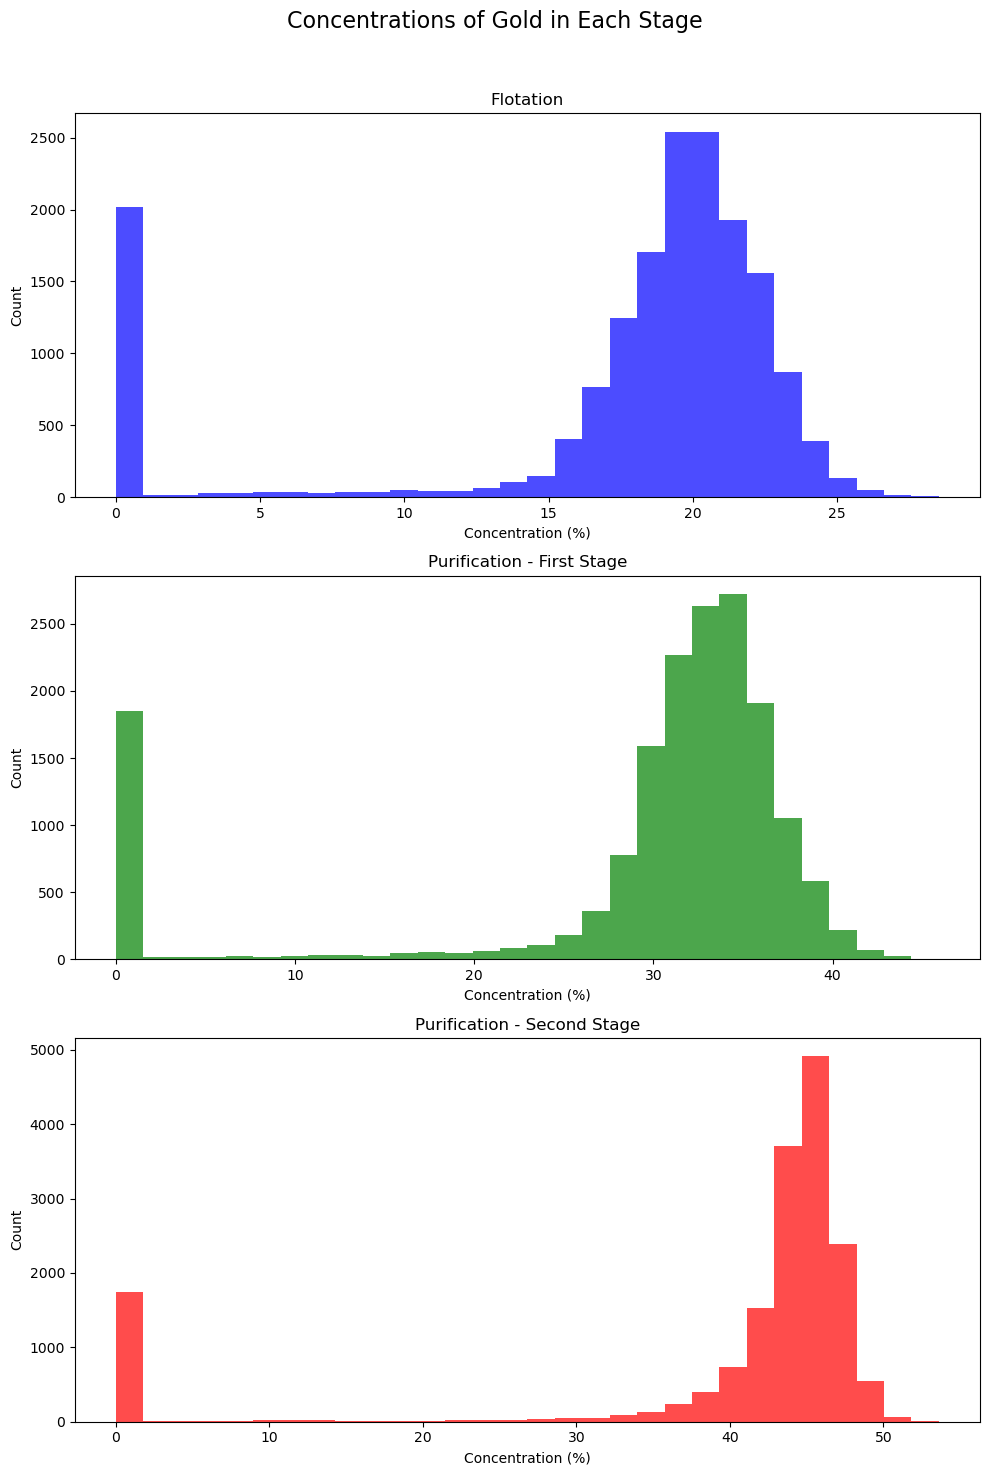

In [15]:
concentrate_chart(train)

**Findings**:

The concentration appears to be normally distributed for all three stages, with the mean of percent concentration increasing as the process progresses - that is with the exception of the presence of several 0s present at each stage. It is not clear if these are true zeros, or an error in the data. The rows with a value of zero at all of the stages will be dropped. 

In [16]:
# Drop all the full zero rows
for i in ['au', 'ag', 'pb']:
    drop = train[(train['rougher.output.concentrate_'+i] == 0) & 
                (train['primary_cleaner.output.concentrate_'+i] == 0) & 
                (train['final.output.concentrate_' +i] == 0)]
    
    train = train.drop(drop.index)

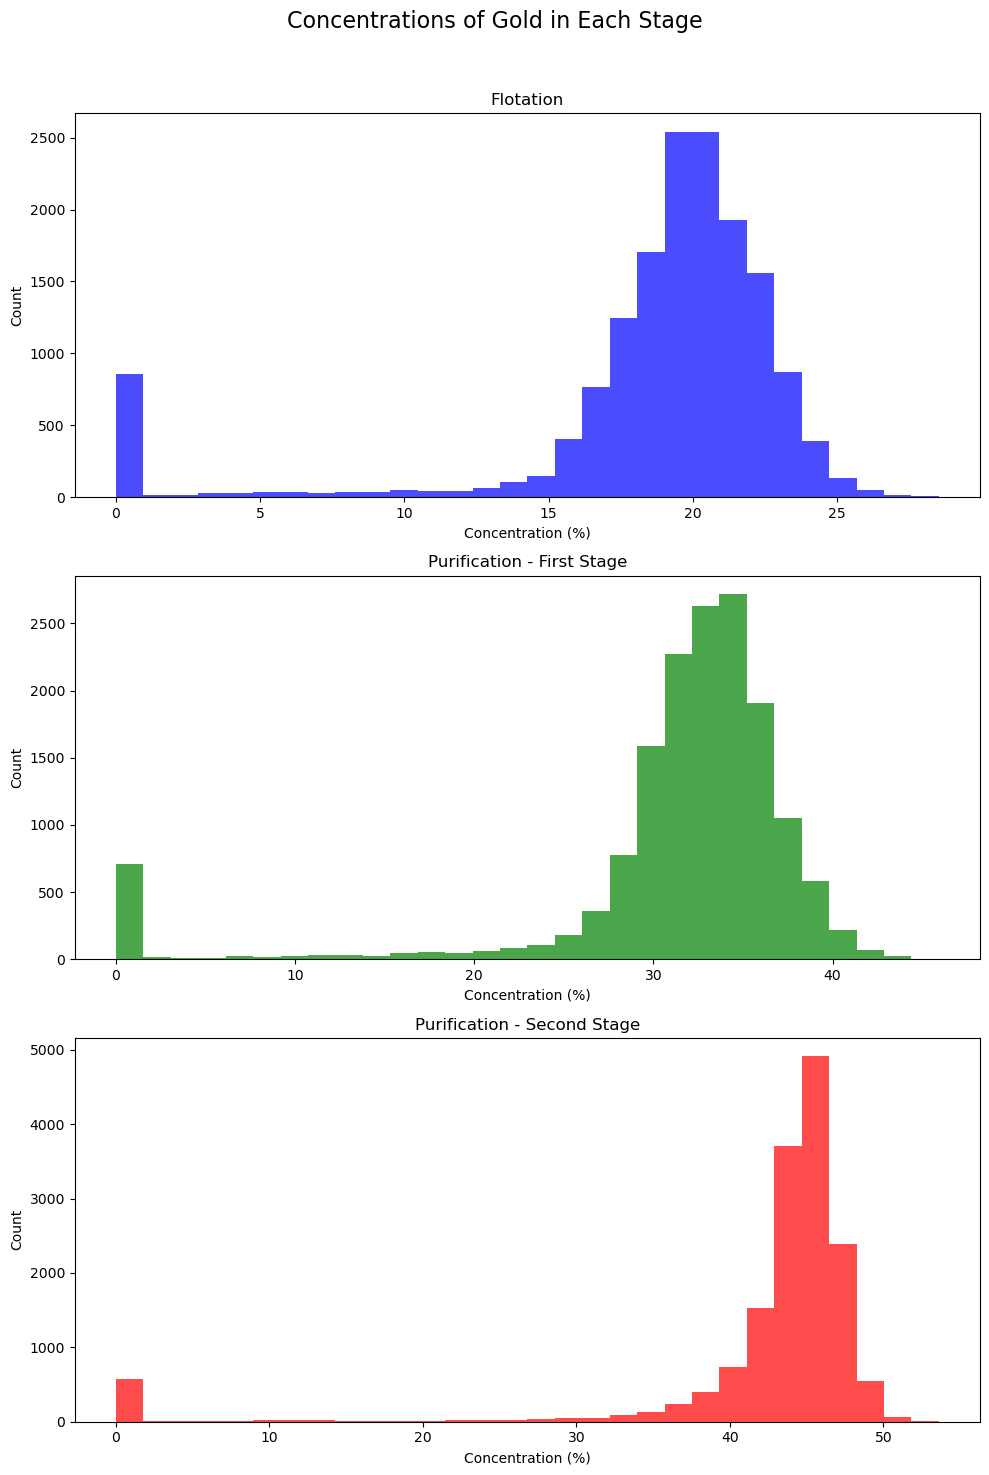

In [17]:
# Verify removal
concentrate_chart(train)

1.B Silver

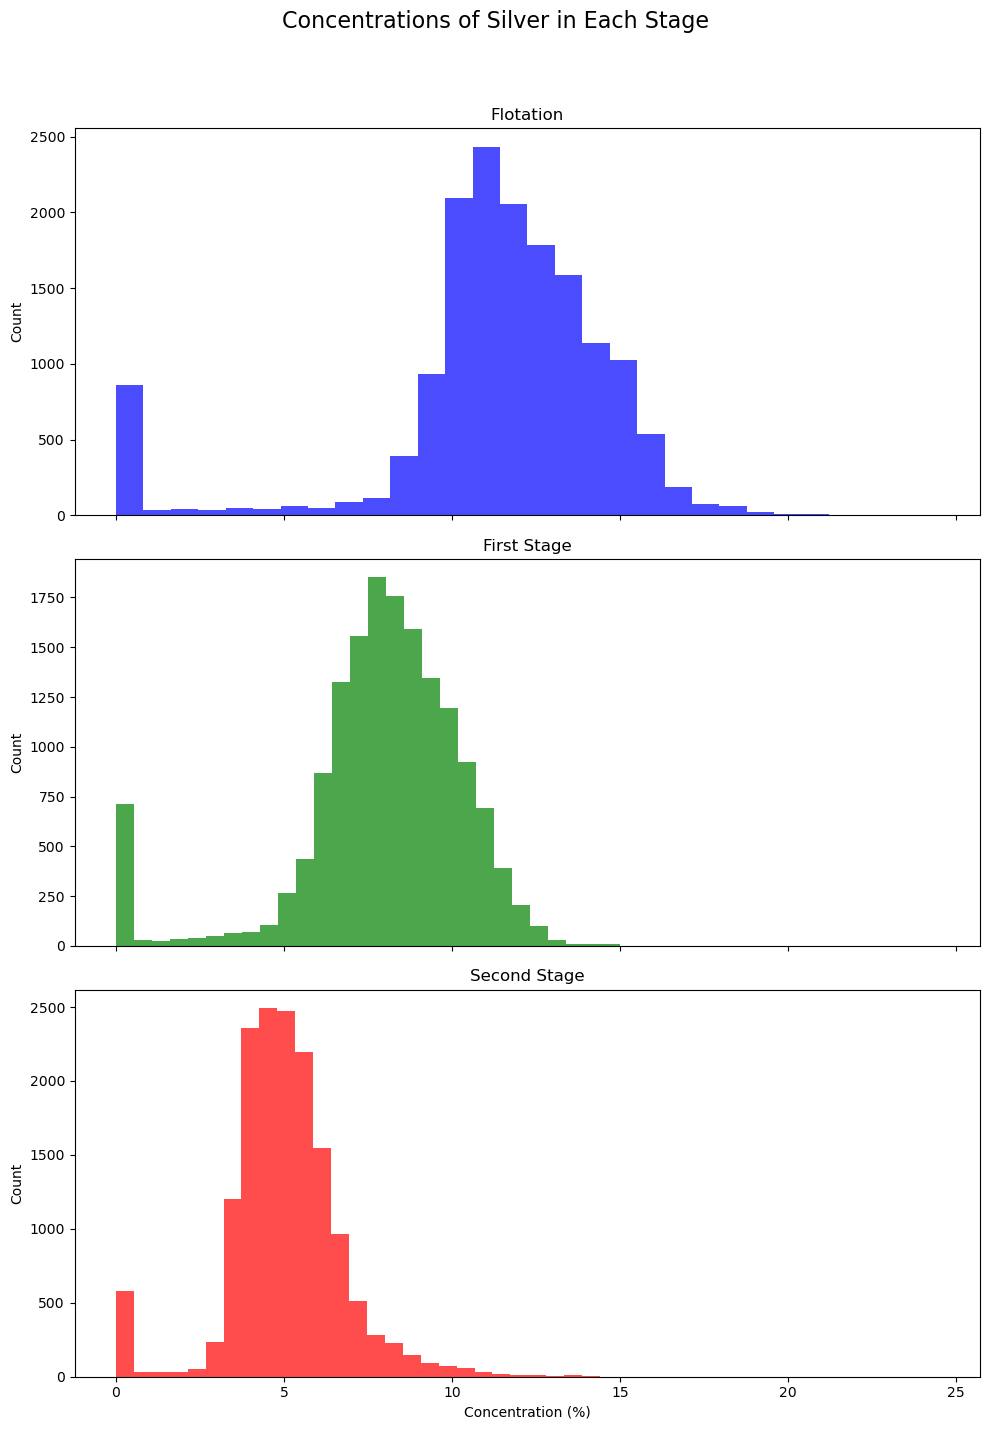

In [18]:
# Define the data
flotation = train['rougher.output.concentrate_ag']
first_stage = train['primary_cleaner.output.concentrate_ag']
second_stage = train['final.output.concentrate_ag']

# Create figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot histogram for each stage
axs[0].hist(flotation, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Flotation')
axs[0].set_ylabel('Count')

axs[1].hist(first_stage, bins=30, color='green', alpha=0.7)
axs[1].set_title('First Stage')
axs[1].set_ylabel('Count')

axs[2].hist(second_stage, bins=30, color='red', alpha=0.7)
axs[2].set_title('Second Stage')
axs[2].set_xlabel('Concentration (%)')
axs[2].set_ylabel('Count')

# Set the main title for the figure
fig.suptitle('Concentrations of Silver in Each Stage', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Findings**:
It can be observed that silver concentration decreases as the process progresses.

1C. Lead

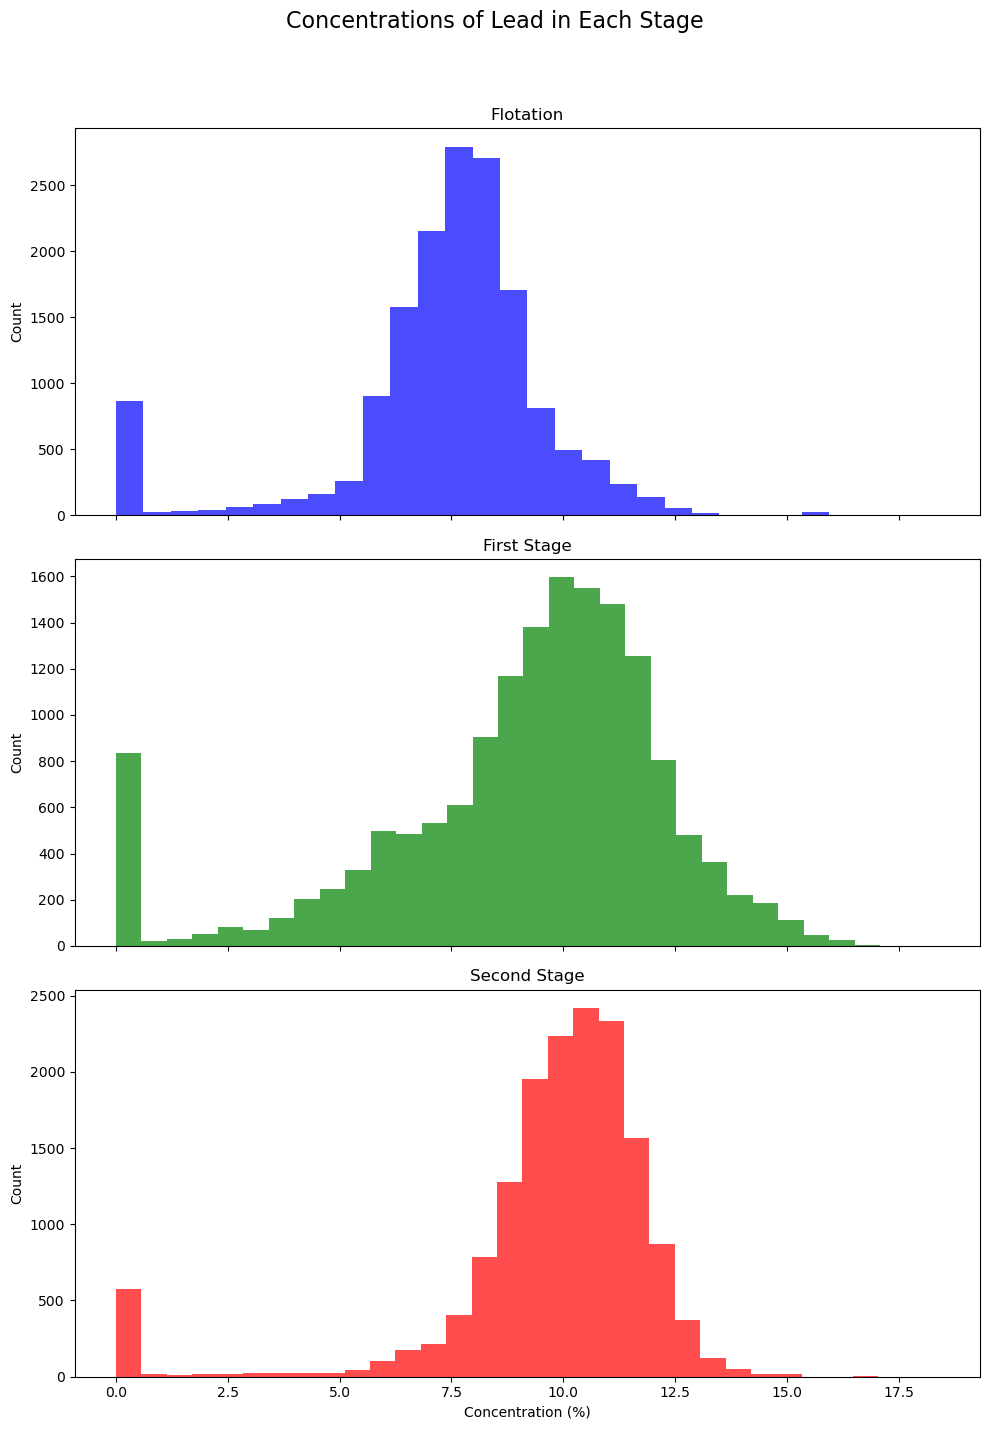

In [19]:
# Define the data
flotation_pb = train['rougher.output.concentrate_pb']
first_stage_pb = train['primary_cleaner.output.concentrate_pb']
second_stage_pb = train['final.output.concentrate_pb']

# Create figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot histogram for each stage
axs[0].hist(flotation_pb, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Flotation')
axs[0].set_ylabel('Count')

axs[1].hist(first_stage_pb, bins=30, color='green', alpha=0.7)
axs[1].set_title('First Stage')
axs[1].set_ylabel('Count')

axs[2].hist(second_stage_pb, bins=30, color='red', alpha=0.7)
axs[2].set_title('Second Stage')
axs[2].set_xlabel('Concentration (%)')
axs[2].set_ylabel('Count')

# Set the main title for the figure
fig.suptitle('Concentrations of Lead in Each Stage', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Findings**

Lead concentration has the least variance across the three stages. 

2D. Cross Comparison of Concentrations 

In [20]:
# Find median concentrations of each metal in each stage
concentrations = pd.DataFrame(columns= ['Gold', 'Silver', 'Lead'], 
                              index=['flotation','first','second'])

# Fill in dataframe with appropriate values
concentrations.loc['flotation'] = [train['rougher.output.concentrate_au'].median(),
                                    train['rougher.output.concentrate_ag'].median(),
                                    train['rougher.output.concentrate_pb'].median()]

concentrations.loc['first'] = [train['primary_cleaner.output.concentrate_au'].median(),
                                      train['primary_cleaner.output.concentrate_ag'].median(),
                                      train['primary_cleaner.output.concentrate_pb'].median()]

concentrations.loc['second'] = [train['final.output.concentrate_au'].median(),
                                      train['final.output.concentrate_ag'].median(),
                                      train['final.output.concentrate_pb'].median()]

concentrations.astype('float').round(2)

,Gold,Silver,Lead
flotation,19.83,11.65,7.70
first,32.97,8.16,9.78
second,44.70,4.98,10.20


**Findings**

Silver steadily decreases as the process progresses. Lead remains with in a 4% window, but increases slightly as the process progresses. 

Gold increases by 13.14% between the first two phases and then by 11.73% between the second and thrid phases. 

**2.  How do the feed particle size distributions in the training set and in the test set compare?**

c:\Users\Leigh\anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Leigh\anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Leigh\anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Leigh\anaconda3\envs\ML\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

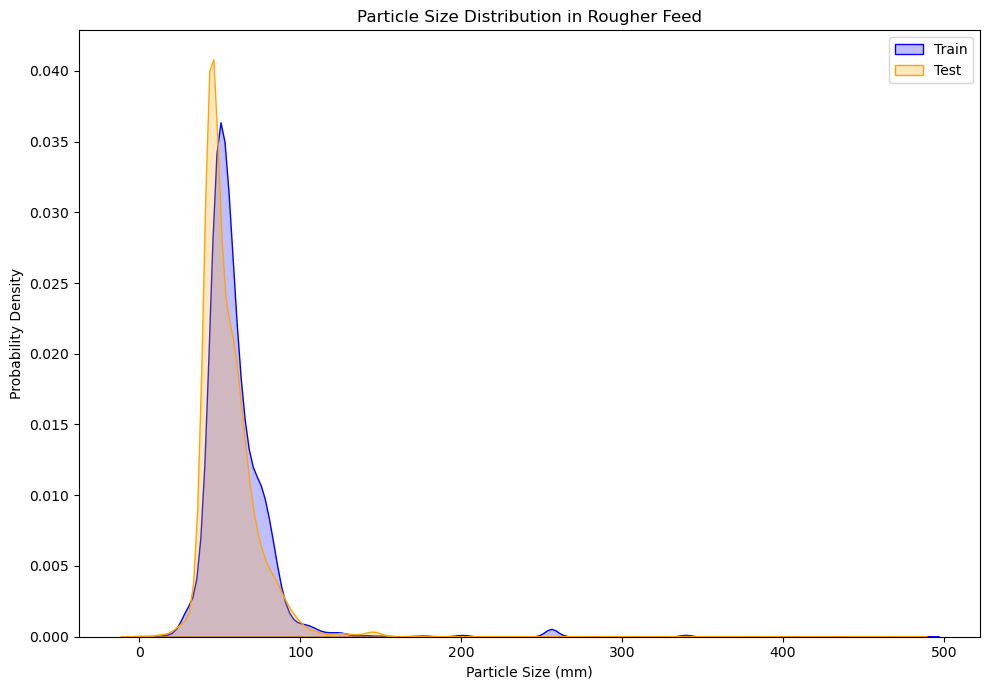

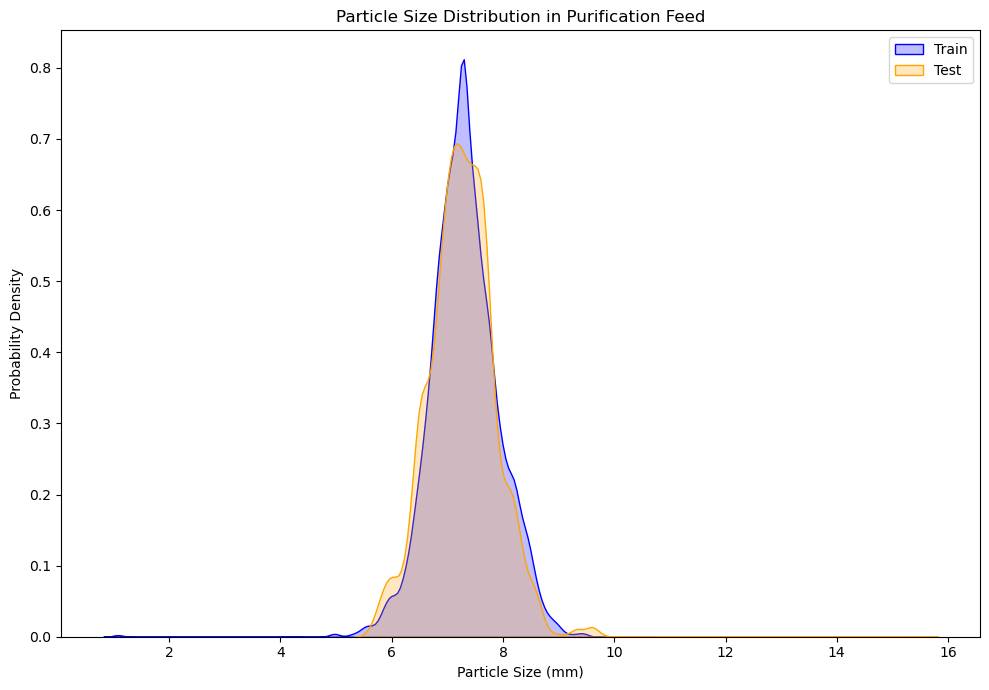

In [21]:
# Define the data
flotation_feed_size_train = train['rougher.input.feed_size']
flotation_feed_size_test = test['rougher.input.feed_size']
purification_feed_size_train = train['primary_cleaner.input.feed_size']
purification_feed_size_test = test['primary_cleaner.input.feed_size']

# Create first figure for Rougher Feed
fig1, ax1 = plt.subplots(figsize=(10, 7))

# Plot probability density functions for flotation feed size
sns.kdeplot(flotation_feed_size_train, ax=ax1, label='Train', color='blue', fill=True, common_norm=False)
sns.kdeplot(flotation_feed_size_test, ax=ax1, label='Test', color='orange', fill=True, common_norm=False)
ax1.set_title('Particle Size Distribution in Rougher Feed')
ax1.set_xlabel('Particle Size (mm)')
ax1.set_ylabel('Probability Density')
ax1.legend()

# Adjust layout to prevent overlap
fig1.tight_layout()

# Create second figure for Purification Feed
fig2, ax2 = plt.subplots(figsize=(10, 7))

# Plot probability density functions for purification feed size
sns.kdeplot(purification_feed_size_train, ax=ax2, label='Train', color='blue', fill=True, common_norm=False)
sns.kdeplot(purification_feed_size_test, ax=ax2, label='Test', color='orange', fill=True, common_norm=False)
ax2.set_title('Particle Size Distribution in Purification Feed')
ax2.set_xlabel('Particle Size (mm)')
ax2.set_ylabel('Probability Density')
ax2.legend()

# Adjust layout to prevent overlap
fig2.tight_layout()

# Show the plots
plt.show()


**Findings**:

For both stages, the particle feed size is very similar. No adjustments are required.

**3.Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Are there any abnormal values in the total distribution?**

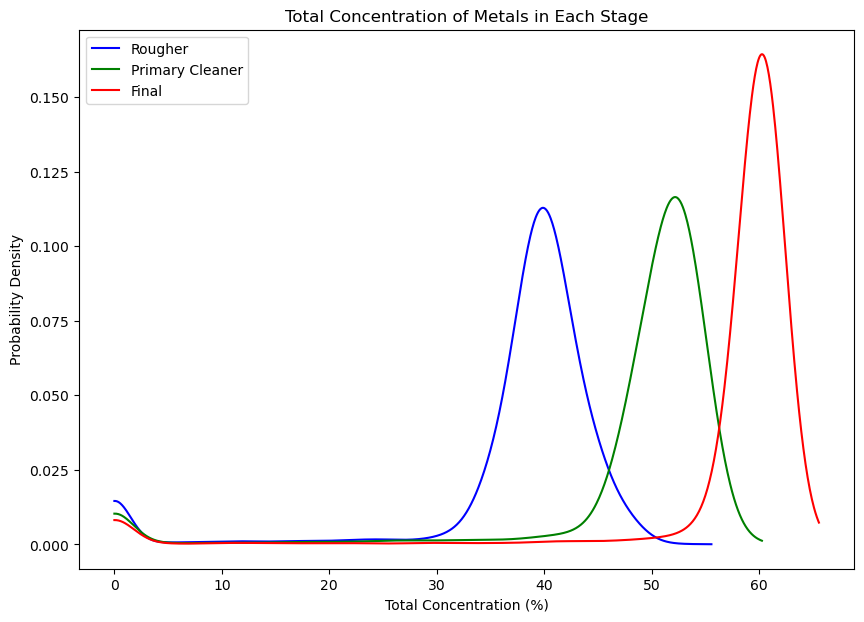

In [22]:
# Create function to find total concentrations of each metal in each stage
def total_concentration(df, stage):
    concentration = df[stage + '.output.concentrate_au'] + df[stage + '.output.concentrate_ag'] + df[stage + '.output.concentrate_pb']
    return concentration

# Find total concentrations of each metal in each stage
for stage in ['rougher', 'primary_cleaner', 'final']:
    train[stage + '.output.concentrate_total'] = total_concentration(train, stage)
    
# Extract the concentration data for each stage
concentration_stages = [
    train['rougher.output.concentrate_total'].dropna(),
    train['primary_cleaner.output.concentrate_total'].dropna(), 
    train['final.output.concentrate_total'].dropna()
]

# Create the figure
plt.figure(figsize=(10, 7))

# Plot KDE for each concentration stage
for data, label, color in zip(concentration_stages, ['Rougher', 'Primary Cleaner', 'Final'], ['blue', 'green', 'red']):
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    plt.plot(x, kde(x), label=label, color=color)

# Update layout
plt.title('Total Concentration of Metals in Each Stage')
plt.xlabel('Total Concentration (%)')
plt.ylabel('Probability Density')
plt.legend()

# Save figure as png
plt.savefig('total_concentration.png')

# Show the plot
plt.show()


**Findings**:
Overall, the total concentration of metals increases as the process progresses. 

### Build and Evaluate Models
---

#### Write a function to calculate the final sMAPE value
sMAPE and Final sMAPE can be calculated using the following:

1. 
$$
\text{sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{\left(\frac{|y_i| + |\hat{y_i}|}{2}\right)} \times 100\%
$$

2. 
$$
\text{Final sMAPE} = 25\% \times \text{sMAPE(rougher)} + 75\% \times \text{sMAPE(final)}
$$


In [23]:
#Create function to calculate sMAPE 
def smape(prediction, target):
    smape = np.mean(abs(prediction - target) / ((abs(target) + abs(prediction)) / 2)) * 100 
    return smape

#Create function to calculate final sMAPE 
def final_smape(target, prediction):
    predicted_rough, predicted_final = prediction[:, 0], prediction[:, 1]
    true_rough, true_final = target[:, 0], target[:, 1]
    final_smape = (.25 * (smape(true_rough, predicted_rough))) + (.75 * (smape(true_final, predicted_final)))
    return final_smape

#### Train and Evaluate Models
Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. 

In [24]:
# Establish the targets and features 
target = train[['rougher.output.recovery','final.output.recovery']].to_numpy()
features = train[test.columns].drop(['date'], axis=1)

# Save smapes as scorer to use in cross validation
smapes = make_scorer(final_smape, greater_is_better=True)

**Linear Regression**

In [25]:

# Create linear regression model
model = LinearRegression()

# Find cross validation scores for each target
final_scores = cross_val_score(model, features, target, cv=5, scoring=smapes)

# Print mean of scores
print("Mean SMAPE:", np.nanmean(final_scores))

Mean SMAPE: 15.513455358242794


**Random Forest Regressor**

In [26]:
# Create random forest model
model = RandomForestRegressor(random_state=12345)

# Define hyperparameters for gridsearch
param_grid = {
    'n_estimators': [30, 40, 50],
    'max_depth': [5, 7, 9]
}

# Find best hyperparameters using gridsearch and cross validation for final smape value
grid_search = GridSearchCV (model, param_grid=param_grid , cv=5, scoring=smapes) 

# Find cross validation scores for each target
best_model = grid_search.fit(features, target)

# Print mean of scores and parameters
print("Mean SMAPE:", best_model.best_score_, '\n', "Best parameters:", best_model.best_params_)


Mean SMAPE: 13.030048479329357 
 Best parameters: {'max_depth': 9, 'n_estimators': 40}


In [27]:
# Gradient Boosting
model = HistGradientBoostingRegressor(random_state=12345)

**Findings**:

The random forrest model appeared to have performed the best, with the lower sMAPE score of 13.03.

### Final Test and Conclusion
---

The best model found in the above step, the Random Forrest Regressor with the max depth of 9 and 40 estimators, will now go through final testing with the test data set.

In [28]:
# Find the target values for test set by merging with full set 
test = test.merge(full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

# drop values where targets are equal to zero
test = test[test['rougher.output.recovery'] != 0]
test = test[test['final.output.recovery'] != 0]

In [29]:
# Establish target
target_test = test[['rougher.output.recovery','final.output.recovery']].to_numpy()

# Establish features
features_test = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)


# Find predictions for test set
prediction_test = best_model.predict(features_test)

# Find final smape score for test set
score = final_smape(target_test, prediction_test)

# Print final_scores
print("Mean SMAPE:", (score))

Mean SMAPE: 9.319031471696555
